# Numerical Exercise 03

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


### Plain vanilla option pricing

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes analytic solution for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

#### Assignment
By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:
1. By sampling **directly** the final asset price $S(T)$ for a $GBM(r,\sigma^2)$
2. By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price 
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

Remember that given an asset price $S\sim GBM(\mu,\sigma^2)$, with initial value $S(0)$, then
    $$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
    where $W(t)\sim\mathcal{N}(0,t)$.
    Moreover, since the increments of $W$ are independent and normally distributed, the simple recursive procedure for sampling discretized values of $S\sim GBM(\mu,\sigma^2)$ at $t_1 < t_2 < … < t_n$ is:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
with $Z_i \sim \mathcal{N}(0,1)$

Make four pictures for the estimation of the European call-option prices, $C[S(0),0]$ (direct and discretized), and put-option prices, $P[S(0),0]$ (direct and discretized), with their uncertainties with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$. As usual, in computing statistical uncertainties, use data blocking.


## Resolution

This exercise requires resolving he problme of option pricing using numerical methods, and confront the results with the analytical solution given by the Black-Scholes equation.


### Financial background in a nutshell
Financial markets are considered time series impossible to predict. As such, asset prices can be modeled as a stochastic process. We can make a few assumptions to tackle this problem.
Financial markets can be assumend to be efficient, meaning that all players have access to the same information, so that the price of an asset is always the fair price.
We instead follow the Markov assumption, which states that the future price of an asset depends only on the current price, and not on the past prices. This is a semplification, and it models the price of an asset as a brownian motion.
To better refine this model, we use a geometric brownian motion, which is a brownian motion with a drift term, which accounts for the average growth of the asset price, and a volatility term, which accounts for the fluctuations of the asset price.

#### Options
Options are contracts that obligate the writer to sell or buy a stock at a certain prefixed price K, at a certain time T. The holder of the option can choose to exercise the option or not. The price of the option is the premium that the holder pays to the seller of the option. For a call option, the difference is $S(T) - K$, while for a put option is $K - S(T)$.
The simplest type of options are the European options, which can be exercised only at the expiration date.
In this case, the holder will exercise the option only if the operation retunrns a profit.
The profit for a call option is:
$$P = \max(0, S(T) - K)$$
The profit for a put option is:
$$P = \max(0, K - S(T))$$

### Simulation
The numerical simulation is done modelling the asset price $S$ as a geometric brownian motion $S\sim\mathcal{GBM}(\mu,\sigma^2)$. The asset price will follow the following equation:
$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
where $W(t)\sim\mathcal{N}(0,t)$ (normal distribution).

We can sample recursively the price at istants $t_i$ as:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
with $Z_i \sim \mathcal{N}(0,1)$

We can now extimate the price of the option as:

$$C[S(0),0] = e^{-rT} \max(0, S(T) - K)$$

$$P[S(0),0] = e^{-rT} \max(0, K - S(T))$$


### Code
Folloqing the previous exercises, this exercise introduces various new classes deriving from `BlockingAvg` for each different type of option, and type of simulation (direct or discretized). The classes are:
- `BlockingDirectCall` for the direct simulation of the call option
- `BlockingDirectPut` for the direct simulation of the put option
- `BlockingDiscreteCall` for the discretized simulation of the call option
- `BlockingDiscretePut` for the discretized simulation of the put option

These classes redefine the `Funny` method to perform the extimation of the option price:

```cpp
void BlockingDirectPut::Funny(Random &rnd){
    sum += exp(-m_r*m_T) * max(0., m_K-Price(rnd));
}
```
 or

```cpp
void BlockingDirectCall::Funny(Random &rnd){
    sum += exp(-m_r*m_T) * max(0., Price(rnd)-m_K);
}
```
Where `Price` computes the price according to the simulation type:

```cpp
double BlockingDirectCall::Price(Random &rnd){
    double w{rnd.Gauss(0., m_T)};
    return m_s0*exp((m_r - 0.5*m_vol*m_vol)*m_T + m_vol*w);
}
```
and

```cpp
double BlockingDiscreteCall::Price(Random &rnd){
    double price{m_s0};
    double h{m_T/(double)100};
    for(int i{0}; i<100; i++){
        double w{rnd.Gauss(0., 1.)};
        price = price * exp((m_r - 0.5*m_vol*m_vol)*h + m_vol*w*sqrt(h));
    }
    return price;
}
```


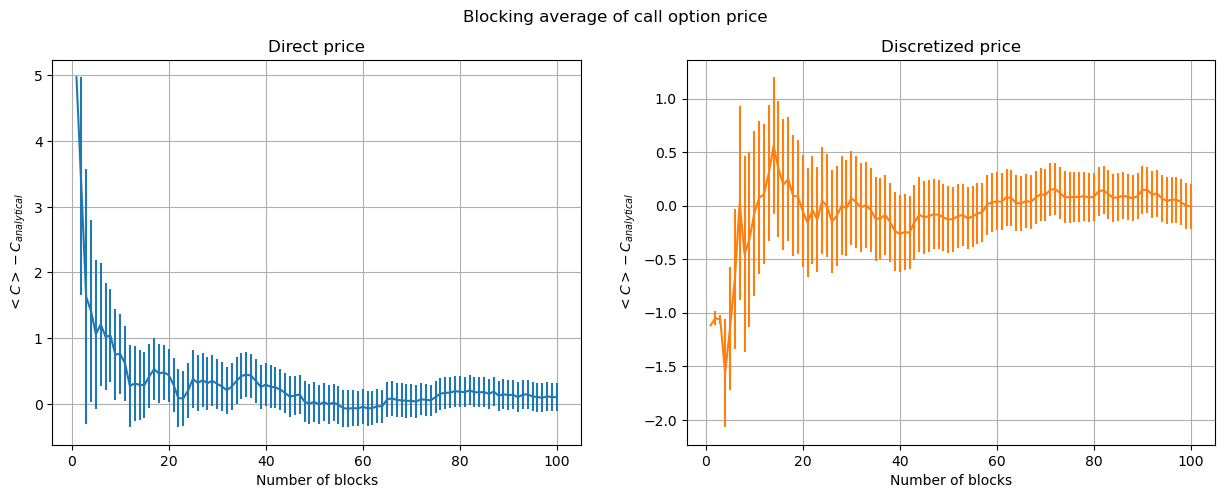

In [19]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_03_call_direct.dat", unpack=True, usecols=(0,1,2))
colour = colors[0]
plt.figure(figsize=(15,5))
call = 14.975790778311286
plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-call, yerr=block_error, color=colors[0])
plt.title("Direct price")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<C> - C_{analytical}$")
plt.grid(True)

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_03_call_discrete.dat", unpack=True, usecols=(0,1,2))

plt.subplot(1,2,2)
plt.errorbar(n_throws, cum_avg-call, yerr=block_error, color=colors[1])
plt.title("Discretized price")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<C> - C_{analytical}$")
plt.grid(True)

plt.suptitle("Blocking average of call option price")

plt.show()

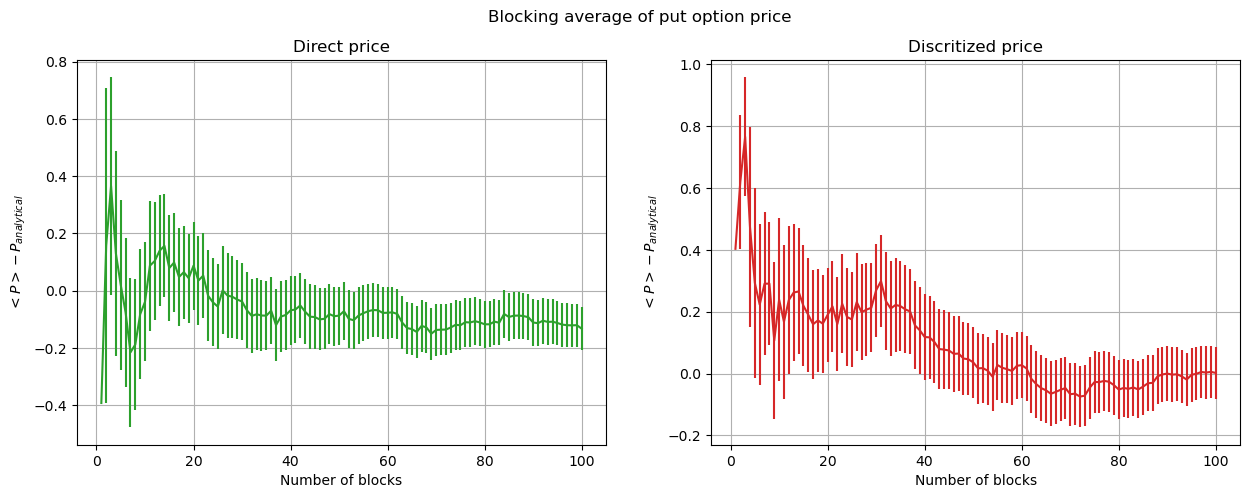

In [20]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_03_put_direct.dat", unpack=True, usecols=(0,1,2))
colour = colors[2]
plt.figure(figsize=(15,5))
put = 5.4595325819072364
plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-put, yerr=block_error, color=colors[2])
plt.title("Direct price")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<P> - P_{analytical}$")
plt.grid(True)

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_03_put_discrete.dat", unpack=True, usecols=(0,1,2))
plt.subplot(1,2,2)
plt.errorbar(n_throws, cum_avg-put, yerr=block_error, color=colors[3])
plt.title("Discritized price")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<P> - P_{analytical}$")
plt.grid(True)

plt.suptitle("Blocking average of put option price")

plt.show()